In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt


from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

In [2]:
## Step 1: Define the problem.

In [3]:
domain = RectangularDomainND
domain_init_kwargs = dict(
    xmin=np.array([0.,]),
    xmax=np.array([1.,]),# solve the problem over the domain [0, 1]
)

In [4]:
## Does this whole thing work without boundary conditions??

class HarmonicOscillator1D(Problem):
    @staticmethod
    def init_params(d=2, w0=20):
        mu, k = 2*d, w0**2
        
        static_params = {
            'dims': (1,1),
            'd': d,
            'w0': w0,
            'mu': mu,
            'k': k,
        }
        return static_params, {}
    
    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()),
            (0,(0,)),
            (0,(0,0))
        )

        x_batch_boundary = jnp.array([0.]).reshape((1,1))
        u_boundary = jnp.array([1.]).reshape((1,1))
        ut_boundary = jnp.array([0.]).reshape((1,1))
        required_ujs_boundary = (
            (0,()),
            (0,(0,)),
        )
        return [
            [x_batch_phys, required_ujs_phys],
            [x_batch_boundary, u_boundary, ut_boundary, required_ujs_boundary]
        ]

    @staticmethod
    def loss_fn(all_params, constraints):
        mu, k = all_params['static']["problem"]['mu'], all_params['static']['problem']['k']
        
        _, u, ut, utt = constraints[0]
        phys = jnp.mean((utt + mu*ut + k*u)**2)

        _, uc, utc, u, ut = constraints[1]
        boundary = 1e6*jnp.mean((u-uc)**2) + 1e2*jnp.mean((ut-utc))

        return phys + boundary

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        d, w0 = all_params['static']['problem']['d'], all_params['static']['problem']['w0']

        w = jnp.sqrt(w0**2-d**2)
        phi = jnp.arctan(-d/w)
        A = 1/(2*jnp.cos(phi))
        cos = jnp.cos(phi + w*x_batch)
        exp = jnp.exp(-d * x_batch)
        return 2*A*cos*exp

problem = HarmonicOscillator1D
problem_init_kwargs=dict(d=2, w0=80)

In [5]:
decomposition = RectangularDecompositionND
decomposition_init_kwargs = dict(
    subdomain_xs = [np.linspace(0,1, 15)],
    subdomain_ws =[0.15*np.ones((15,))],
    unnorm=(0.,1.),
)

In [6]:
network = FCN
network_init_kwargs = dict(
    layer_sizes = [1,32,1],
)

In [7]:
c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((200,),),
    n_test=(500,),
    n_steps=20000,
    clear_output=True)
print(c)

run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0.]), 'xmax': array([1.])}
problem: <class '__main__.HarmonicOscillator1D'>
problem_init_kwargs: {'d': 2, 'w0': 80}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])], 'subdomain_ws': [array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [1, 32, 1]}
n_steps: 20000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200,),)
n_test: (500,)
sampler: grid
optimiser: <function adam at 0x79c85e561940>
optimiser_kwargs: {'learning_rate': 0.00

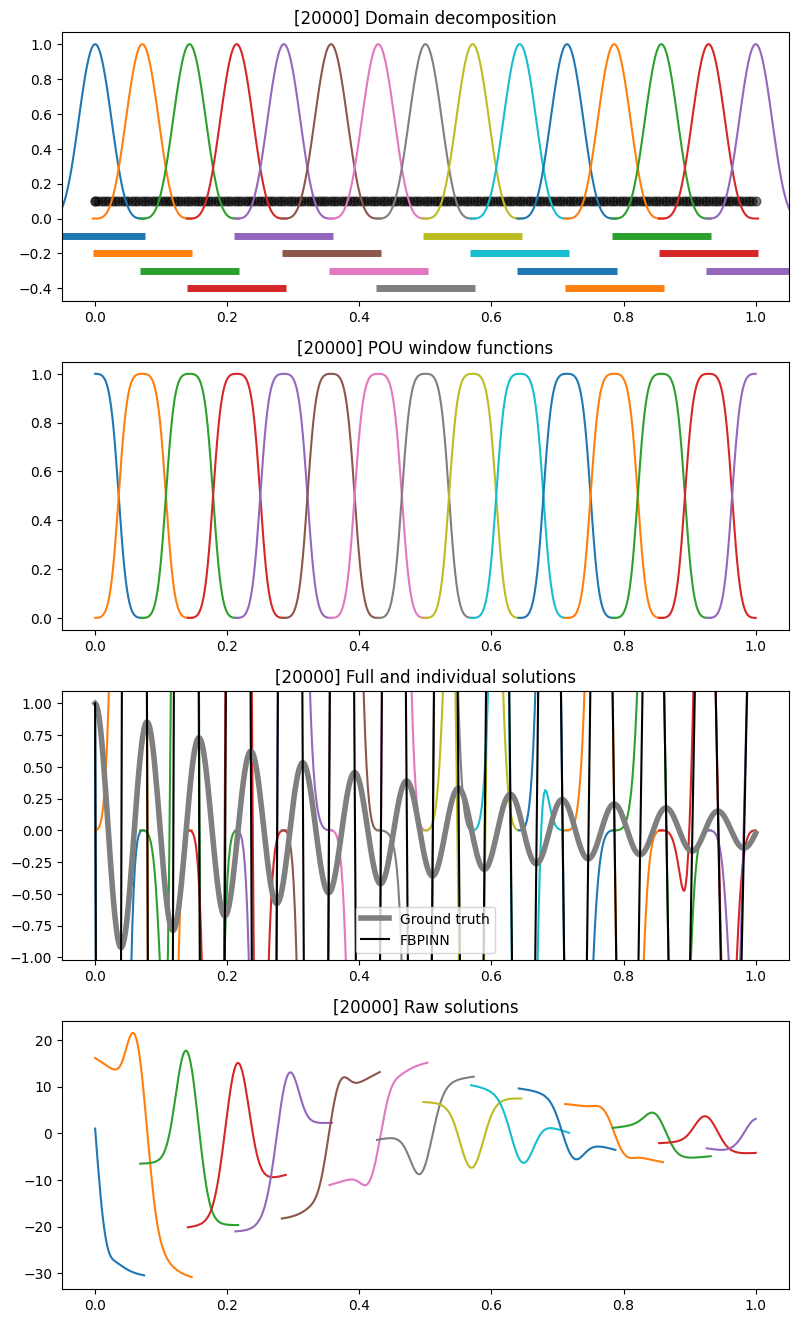

[INFO] 2024-05-02 01:23:32 - [i: 20000/20000] Training complete


In [8]:
run = FBPINNTrainer(c)
all_params = run.train()

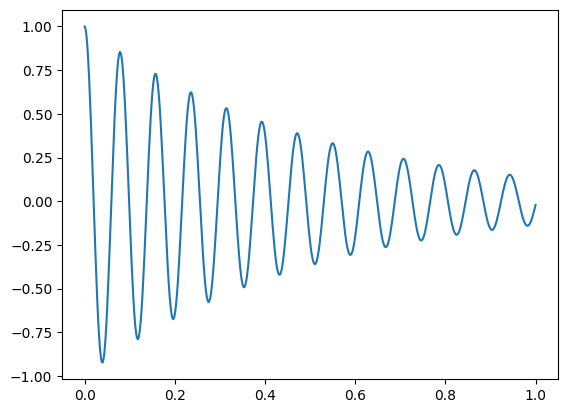

In [11]:
plt.plot(x_batch, u)

In [12]:
x_batch_soliton = jnp.linspace(-5, 5, 250)
t_batch_soliton = jnp.linspace(0, jnp.pi/2, 250)
x, t = jnp.meshgrid(x_batch_soliton,t_batch_soliton)

In [13]:
c, a = 1, 1
phi = 0.5*c*1/jnp.cosh(jnp.sqrt(c)/2*(x-c*t-a))**2

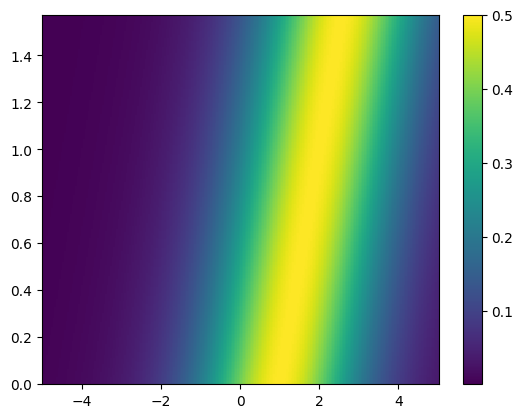

In [14]:
plt.pcolormesh(x, t, phi)
plt.colorbar()
plt.show()